cell 1

In [ ]:
#imports and paths
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    confusion_matrix,
    classification_report
)

import joblib

# Paths
DATA_DIR = "../data"
PROCESSED_DIR = os.path.join(DATA_DIR, "processed")

PROCESSED_DIR

'../data/processed'

cell 2

In [17]:
# Load best model (saved in 02_modeling)
best_model = joblib.load(os.path.join(PROCESSED_DIR, "best_model.pkl"))

# Load validation features and labels (saved as numpy arrays in 02_modeling)
X_val = np.load(os.path.join(PROCESSED_DIR, "X_val.npy"))
y_val = np.load(os.path.join(PROCESSED_DIR, "y_val.npy"))

# Optional: load indices of validation rows in train_full (for FP/FN case studies)
val_indices_path = os.path.join(PROCESSED_DIR, "val_indices.npy")
val_indices = None
if os.path.exists(val_indices_path):
    val_indices = np.load(val_indices_path)

# Load provider-level training data for reference (from Notebook 1)
train_full = pd.read_csv(os.path.join(PROCESSED_DIR, "train_provider_features.csv"))

X_val.shape, y_val.shape, train_full.shape

((1082, 27), (1082,), (5410, 30))

cell 3

In [18]:
# Predicted fraud probabilities on validation set
y_proba_val = best_model.predict_proba(X_val)[:, 1]

# Default threshold = 0.5
y_pred_val = (y_proba_val >= 0.5).astype(int)

roc = roc_auc_score(y_val, y_proba_val)
pr_auc = average_precision_score(y_val, y_proba_val)

print("ROC-AUC:", roc)
print("PR-AUC :", pr_auc)
print("\nClassification report (threshold = 0.5):")
print(classification_report(y_val, y_pred_val))

print("Confusion matrix (threshold = 0.5):")
cm = confusion_matrix(y_val, y_pred_val)
cm

ROC-AUC: 0.9885649115370253
PR-AUC : 0.9332168154384467

Classification report (threshold = 0.5):
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       981
           1       0.97      0.73      0.84       101

    accuracy                           0.97      1082
   macro avg       0.97      0.87      0.91      1082
weighted avg       0.97      0.97      0.97      1082

Confusion matrix (threshold = 0.5):


array([[979,   2],
       [ 27,  74]])

cell 4

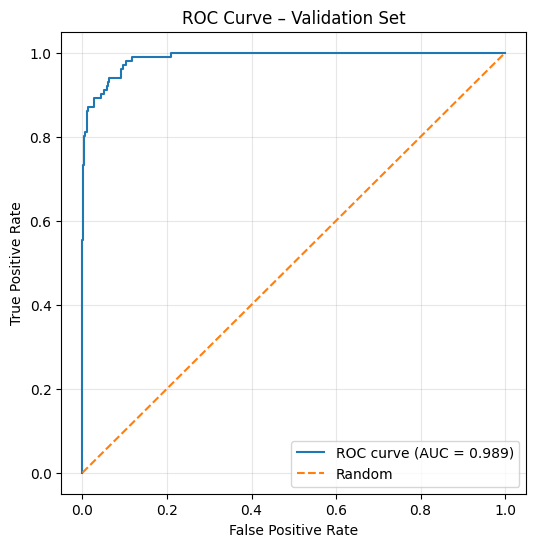

In [ ]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_val, y_proba_val)

plt.figure(figsize=(6, 6))
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", label="Random")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Validation Set")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

cell 5

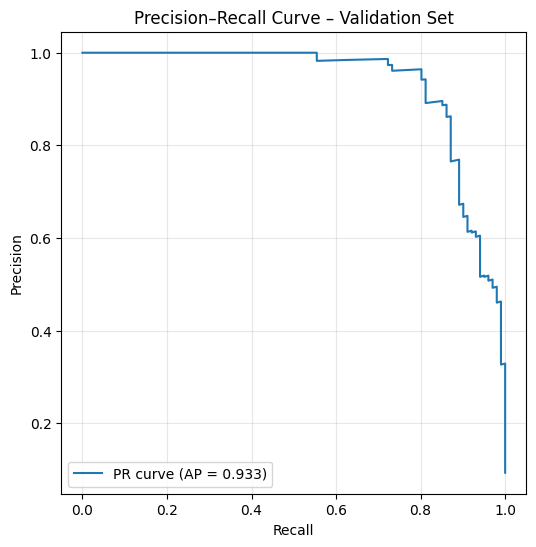

In [ ]:
# Plot Precision-Recall curve
prec, rec, _ = precision_recall_curve(y_val, y_proba_val)

plt.figure(figsize=(6, 6))
plt.plot(rec, prec, label=f"PR curve (AP = {pr_auc:.3f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve – Validation Set")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

cell 6

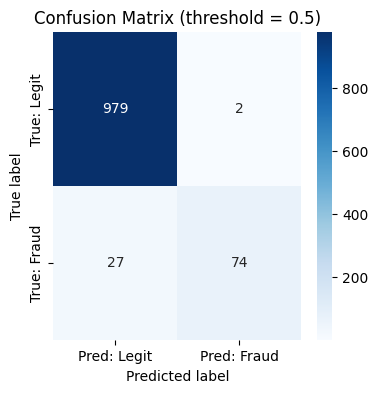

TN (true legit): 979
FP (legit but flagged as fraud): 2
FN (fraud missed): 27
TP (fraud correctly flagged): 74


In [ ]:
# Confusion matrix heatmap
cm = confusion_matrix(y_val, y_pred_val)

plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Pred: Legit", "Pred: Fraud"],
            yticklabels=["True: Legit", "True: Fraud"])
plt.title("Confusion Matrix (threshold = 0.5)")
plt.ylabel("True label")
plt.xlabel("Predicted label")
plt.show()

tn, fp, fn, tp = cm.ravel()
print(f"TN (true legit): {tn}")
print(f"FP (legit but flagged as fraud): {fp}")
print(f"FN (fraud missed): {fn}")
print(f"TP (fraud correctly flagged): {tp}")

cell 7

In [ ]:
# Evaluate metrics at different thresholds
thresholds = np.linspace(0.1, 0.9, 9)
print("Threshold  Precision  Recall")

for thr in thresholds:
    y_thr = (y_proba_val >= thr).astype(int)
    cm_thr = confusion_matrix(y_val, y_thr)
    tn_t, fp_t, fn_t, tp_t = cm_thr.ravel()

    precision = tp_t / (tp_t + fp_t) if (tp_t + fp_t) > 0 else 0
    recall = tp_t / (tp_t + fn_t) if (tp_t + fn_t) > 0 else 0

    print(f"{thr:8.2f}  {precision:9.3f}  {recall:6.3f}")

Threshold  Precision  Recall
    0.10      0.495   0.970
    0.20      0.664   0.901
    0.30      0.786   0.871
    0.40      0.911   0.812
    0.50      0.974   0.733
    0.60      0.985   0.644
    0.70      1.000   0.554
    0.80      1.000   0.495
    0.90      1.000   0.406


cell 8

,feature,importance
1,inp_total_reimbursed,0.575584
7,outp_claims,0.085552
8,outp_total_reimbursed,0.062545
5,inp_mean_los,0.043129
11,outp_unique_bene,0.029515
6,inp_unique_bene,0.025386
0,inp_claims,0.024565
3,inp_max_reimbursed,0.016522
24,mean_ChronicCond_Osteoporasis,0.016019
26,mean_ChronicCond_stroke,0.013875


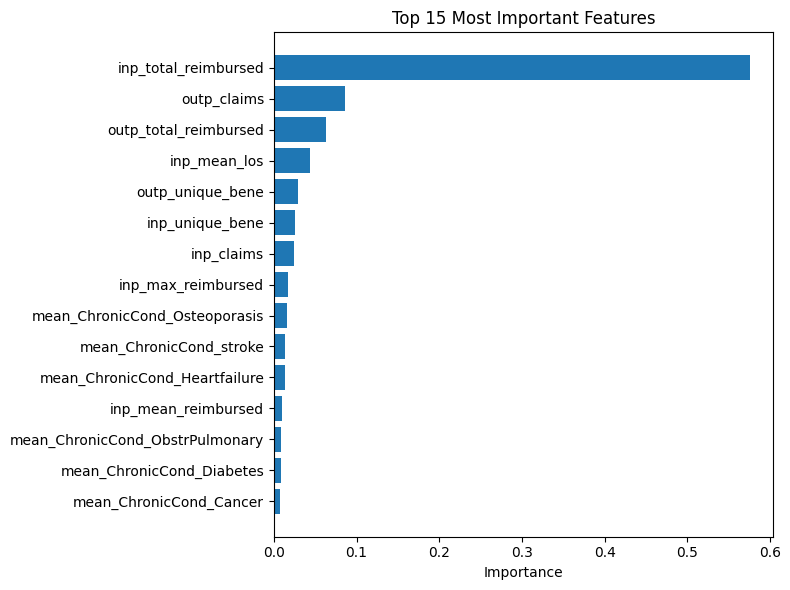

In [ ]:
# Feature importance plot

# Only works if best_model is a tree-based model like RandomForest or GradientBoosting
if hasattr(best_model, "feature_importances_"):
    # Reload feature column names from train_full
    feature_cols = [c for c in train_full.columns
                    if c not in ["Provider", "PotentialFraud", "FraudLabel"]]

    # If you dropped some columns in 02_modeling, feature_cols there might differ.
    # Optionally load the feature list from a saved file if you exported it.
    importances = best_model.feature_importances_

    feat_imp = pd.DataFrame({
        "feature": feature_cols,
        "importance": importances
    }).sort_values("importance", ascending=False)

    # show top features
    display(feat_imp.head(20))

    # plot top K features
    top_k = 15
    top_feat = feat_imp.head(top_k).iloc[::-1]  # reverse for nicer barh plot

    plt.figure(figsize=(8, 6))
    plt.barh(top_feat["feature"], top_feat["importance"])
    plt.title(f"Top {top_k} Most Important Features")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()
else:
    print("best_model has no feature_importances_ attribute.")

In [ ]:
# Analyze false positives and false negatives by provider
if val_indices is None:
    print("val_indices.npy not found. You need to save val_indices in 02_modeling to do provider-level FP/FN analysis.")
else:
    # DataFrame of validation results
    val_results = pd.DataFrame({
        "index_in_train_full": val_indices,
        "y_true": y_val,
        "y_proba": y_proba_val,
        "y_pred": y_pred_val
    })

    # Merge with train_full to get Provider and features
    val_merged = val_results.merge(
        train_full.reset_index().rename(columns={"index": "train_index"}),
        left_on="index_in_train_full",
        right_on="train_index",
        how="left"
    )

    # False Positives: predicted 1, true 0
    fp_cases = val_merged[(val_merged["y_true"] == 0) & (val_merged["y_pred"] == 1)]
    # False Negatives: predicted 0, true 1
    fn_cases = val_merged[(val_merged["y_true"] == 1) & (val_merged["y_pred"] == 0)]

    print("Number of false positives:", len(fp_cases))
    print("Number of false negatives:", len(fn_cases))

    # Show a few example rows for manual analysis
    fp_cases[["Provider", "y_true", "y_pred", "y_proba",
              "inp_claims", "outp_claims", "avg_age"]].head(3)

Number of false positives: 2
Number of false negatives: 27


In [ ]:
# Show a few example rows for manual analysis
if val_indices is not None:
    fn_cases[["Provider", "y_true", "y_pred", "y_proba",
              "inp_claims", "outp_claims", "avg_age"]].head(3)